<a href="https://colab.research.google.com/github/SuriyaG09/InnoVerify-NFT-Backed-Idea-Validation-using-AI-and-Blockchain/blob/main/Tarp_project_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as sw
import nltk
from bs4 import BeautifulSoup

from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import string


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/AI_dataset/'

In [ ]:
!kaggle datasets download Cornell-University/arxiv

100% 1.18G/1.19G [00:15<00:00, 73.8MB/s]
100% 1.19G/1.19G [00:15<00:00, 84.3MB/s]


In [ ]:
!unzip '/content/arxiv.zip'

Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [ ]:
DATASET_PATH = "/content/arxiv-metadata-oai-snapshot.json"

# The number of papers on which the models will be trained and that also will be analyzed.
# There are over 2 million papers in this dataset, I'll select a subset.
NUM_PAPERS = 500000

In [ ]:
def get_dataset_generator(path: str) -> Generator:
    with open(path, "r") as fp:
        for line in fp:
            row = json.loads(line)
            yield row


dataset_generator = get_dataset_generator(
    path=DATASET_PATH
)
print(type(dataset_generator))

<class 'generator'>


In [ ]:
def create_dataframe(generator: Generator) -> pd.DataFrame:
    # I'll use this column to filter out paper duplicates.
    titles = []
    authors = []

    abstracts = []
    categories = []
    dates = []

    for row in generator:
        if len(abstracts) == NUM_PAPERS:
            break

        titles.append(row["title"])
        authors.append(row["authors"])

        dates.append(row["update_date"])
        abstracts.append(row["abstract"])
        categories.append(row["categories"])

    return pd.DataFrame.from_dict({
        "title": titles,
        "authors": authors,
        "date": dates,
        "abstract": abstracts,
        "categories": categories
    })


dataset_df = create_dataframe(dataset_generator)
dataset_df["date"] = pd.to_datetime(dataset_df["date"])

In [ ]:
print(f"Dataset Samples: {len(dataset_df):,}")
dataset_df.head()

Dataset Samples: 500,000


,title,authors,date,abstract,categories
0,Calculation of prompt diphoton production cros...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",2008-11-26,A fully differential calculation in perturba...,hep-ph
1,Sparsity-certifying Graph Decompositions,Ileana Streinu and Louis Theran,2008-12-13,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG
2,The evolution of the Earth-Moon system based o...,Hongjun Pan,2008-01-13,The evolution of Earth-Moon system is descri...,physics.gen-ph
3,A determinant of Stirling cycle numbers counts...,David Callan,2007-05-23,We show that a determinant of Stirling cycle...,math.CO
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,Wael Abu-Shammala and Alberto Torchinsky,2013-10-15,In this paper we show how to compute the $\L...,math.CA math.FA


In [ ]:
print("Missing values by column:")
dataset_df.isnull().sum()

Missing values by column:


title         0
authors       0
date          0
abstract      0
categories    0
dtype: int64

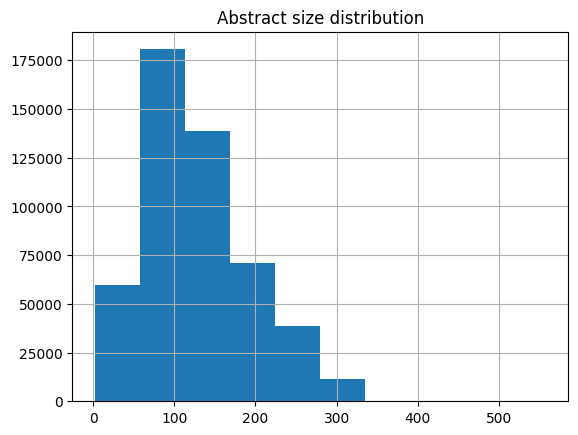

In [ ]:
# I'll naively split the text by whitespace directly. It should be okay for an approximation.
# I might've alternatively tokenized using SpaCy, for example, or a HuggingFace WordPiece Tokenizer, for that matter.
dataset_df["abstract_len"] = dataset_df["abstract"].apply(lambda text: len(text.split()))
dataset_df["abstract_len"].hist()
plt.title("Abstract size distribution")
plt.show()

Number of categories per paper description:
count    500000.000000
mean          1.638130
std           0.870989
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: num_categories, dtype: float64


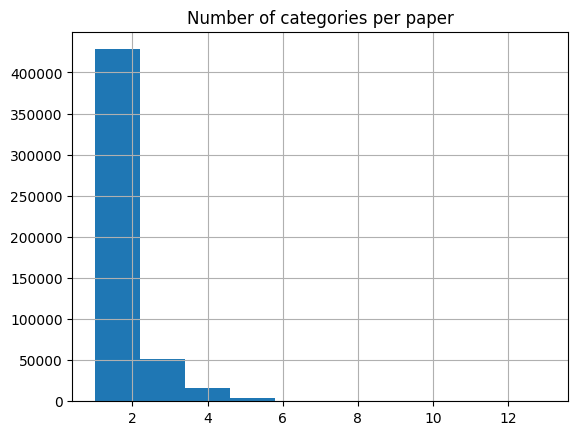

In [ ]:
# Splitting the string of space-separated categories into a list.
dataset_df["categories"] = dataset_df["categories"].apply(
    lambda text: tuple(text.split())
)
# Displaying the distribution of number of categories.
dataset_df["num_categories"] = dataset_df["categories"].apply(
    lambda cats: len(cats)
)
print("Number of categories per paper description:")
print(dataset_df["num_categories"].describe())

dataset_df["num_categories"].hist()
plt.title("Number of categories per paper")
plt.show()

In [ ]:
categories = dataset_df["categories"].tolist()

# Getting all unique categories by flattening the 'categories' column
# and creating a set out of the resultant list.
unique_categories = set([
    cat
    for nested_cats in categories
    for cat in nested_cats
])
print(f"Num. unique categories: {len(unique_categories)}")

Num. unique categories: 155


Earliest date: 2007-05-23 00:00:00
Latest date: 2023-08-25 00:00:00
Most frequently occurring category: hep-ph
Least frequently occurring category: econ.GN


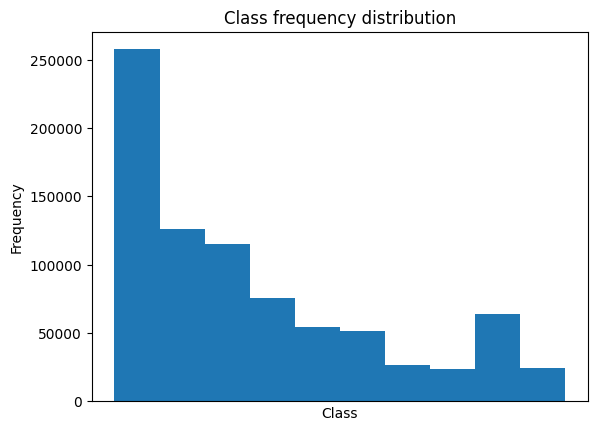

In [ ]:
print(f"Earliest date: {dataset_df['date'].min()}")
print(f"Latest date: {dataset_df['date'].max()}")

all_categories = dataset_df["categories"].tolist()
all_categories = [
    cat
    for nested_cats in all_categories
    for cat in nested_cats
]

print(
    "Most frequently occurring category:",
    max(set(all_categories), key=all_categories.count)
)
print(
    "Least frequently occurring category:",
    min(set(all_categories), key=all_categories.count)
)

plt.hist(all_categories)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
)
plt.tick_params(
    axis='y',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
)
plt.title("Class frequency distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print(f"Num. papers: {len(dataset_df)}")
dataset_df = dataset_df[~dataset_df[["title", "authors"]].duplicated()]
print(f"Num. unique papers: {len(dataset_df)}")

Num. papers: 500000
Num. unique papers: 499821
